<a href="https://colab.research.google.com/github/dvarkless/InnopolisDS/blob/main/homeworks/ResNet34_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import sys
from collections import OrderedDict
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from PIL import ImageFile
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import datasets, models, transforms
from torchvision.transforms import Compose, Normalize, ToTensor

ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

Эта функция использовалась раннее для получения матожидания и СКО датасета

In [20]:
def get_normalize_coeffs(loader: DataLoader):
    mean = 0.0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
    mean = mean / len(loader.dataset)

    var = 0.0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        var += ((images - mean.unsqueeze(1))**2).sum([0, 2])
    std = torch.sqrt(var / (len(loader.dataset)*224*224))
    return mean, std


In [21]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [22]:
def visualize_model(model, dataloader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [23]:
class FineTrainer:
    __defaults = {
        'batch_size': 100,
        'max_epochs': 20,
        'criterion': nn.CrossEntropyLoss(),
        'log': False,
        'metric': None,
    }

    def __init__(self, model, device, optimizer, **hp) -> None:
        self.device = torch.device(device)
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.config = deepcopy(self.__defaults)
        self.__best_model_params = deepcopy(self.model.state_dict())
        for name, val in hp.items():
            self.config[name] = val

    @property
    def best_model_params(self):
        return self.__best_model_params

    @best_model_params.setter
    def best_model_params(self, _):
        pass

    def train_step(self, train_dataset):
        self.model.train()
        train_dl = DataLoader(
            train_dataset, batch_size=self.config['batch_size'], shuffle=True)
        for image, target in train_dl:
            image = image.to(self.device)
            target = target.to(self.device)
            criterion = self.config['criterion']
            outputs = self.model(image)
            loss = criterion(outputs, target)
            loss.backward()
            self.optimizer.step()

    def fit(self, train_dataset, val_dataset):
        current_state = deepcopy(self.model.state_dict())
        best_metric = 0.0
        patience = self.config.get('patience', 999)
        for epoch in range(self.config['max_epochs']):
            if patience <= 0:
                break
            patience -= 1
            self.optimizer.zero_grad()
            self.train_step(train_dataset)
            loss, metric = self.evaluate(val_dataset)
            metric = metric.double()
            if metric > best_metric:
                best_metric = metric
                current_state = deepcopy(self.model.state_dict())
                patience = self.config.get('patience', 999)

            if self.config['log']:
                print(
                    f'==============Epoch {epoch+1}/{self.config["max_epochs"]}================')
                print(f'Loss: {loss}')
                print(f'{self.config["metric"].__class__.__name__}: {metric}')

        self.__best_model_params = current_state
        return self

    def evaluate(self, val_dataset):
        self.model.eval()
        with torch.no_grad():
            batch_size = self.config.get(
                'val_batch_size', self.config['batch_size'])
            val_dl = DataLoader(val_dataset, batch_size=batch_size)
            len_dl = len(val_dl)
            res_loss = 0
            res_metric = 0
            for image, target in val_dl:
                image = image.to(self.device)
                target = target.to(self.device)
                outputs = self.model(image)
                _, preds = torch.max(outputs, 1)

                metric = self.config['metric']
                criterion = self.config['criterion']

                loss = criterion(outputs, target)

                res_loss += loss.item()
                res_metric += metric(preds, target)
            res_loss /= len_dl
            res_metric /= len_dl

        return res_loss, res_metric


In [24]:
device = torch.device(
        'cuda') if torch.cuda.is_available() else torch.device('cpu')
mean = [0.4884, 0.4509, 0.4118]
std = [0.259, 0.25, 0.2519]
transform_data = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std),
                                        ])


In [25]:
# расположение датасета
root = Path("/run/media/dvarkless/LinuxData/Files/Учеба/Data_Science_Course/NN_architectures/")
path = Path("kagglecatsanddogs_5340/PetImages/")
dataset = datasets.ImageFolder(root/path,transform=transform_data)
train_len = int(len(dataset)*0.8)
dataset_lens = [train_len, len(dataset)-train_len]
train_dataset, val_dataset = random_split(
    dataset, dataset_lens)

class_names = ['Cat', 'Dog']

Создаем классификатор на основе полносвязных слоев и добавляем его в конец модели. В дальнейшем будем обучать именно его.

In [26]:
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
resnet_classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(num_ftrs, 100)),
        ('relu1', nn.ReLU()),
        ('drop2', nn.Dropout(0.5)),
        ('out', nn.LogSoftmax(dim=1)),
])
)
model.fc = resnet_classifier

In [27]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
optimizer = torch.optim.Adam(params=model.fc.parameters(), lr=1e-5)
metric = Accuracy(num_classes=2, average='macro').to(device)
model_tuner = FineTrainer(model, device, optimizer, criterion=nn.NLLLoss(), val_batch_size=64, batch_size=16,
                            patience=1, max_epochs=9, metric=metric, log=True)

In [31]:
model_tuner.fit(train_dataset, val_dataset)

==============Epoch 1/9================
Loss: 0.6924611899671675
Accuracy: 0.9714607000350952
==============Epoch 2/9================
Loss: 0.7425318096257463
Accuracy: 0.9706259965896606


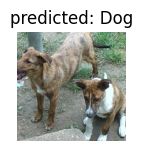

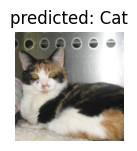

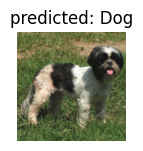

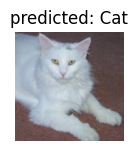

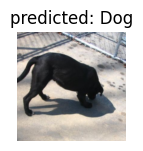

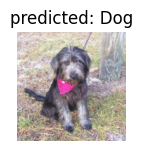

In [32]:
test_dl = DataLoader(val_dataset, batch_size=6, shuffle=True)
visualize_model(model, test_dl)

Сохранение весов модели:

In [33]:
model.load_state_dict(model_tuner.best_model_params)
name = path('resnet34_catsanddogs_fc_tune.pth')
torch.save(model.state_dict(), root / name)

Загрузка чекпоинта при необходимости:

In [ ]:
state_dict = torch.load(root / name)
model.load_state_dict(state_dict)

In [34]:
for param in model.parameters():
    param.requires_grad = True
model.fc.requires_grad = False

In [38]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5)
metric = Accuracy(num_classes=2, average='macro').to(device)
model_tuner = FineTrainer(model, device, optimizer, criterion=nn.NLLLoss(), val_batch_size=32, batch_size=32,
                            patience=2, max_epochs=10, metric=metric, log=True)

In [36]:
loss, acc = model_tuner.evaluate(val_dataset)
print(f'Loss: {loss:.5f}; Accuracy: {acc:.5f}')

Loss: 0.69121; Accuracy: 0.97144


В теории, после обучения классификатора, можно тренировать всю модель для получения более точных предсказаний, однако в данном случае точность модели сразу падает с 0.97 до 0.7.

В итоге, после обучения методом Transfer Learning, получаем модель ResNet50 с точностью 

In [39]:
model_tuner.fit(train_dataset, val_dataset)

==============Epoch 1/10================
Loss: 0.6901405184132279
Accuracy: 0.9381862878799438
==============Epoch 2/10================
Loss: 0.5370189566521129
Accuracy: 0.9497414231300354
==============Epoch 3/10================
Loss: 0.5080549747321257
Accuracy: 0.956447422504425
==============Epoch 4/10================
Loss: 0.4696135679437856
Accuracy: 0.9649229645729065
==============Epoch 5/10================
Loss: 0.5399627651378607
Accuracy: 0.9556320309638977
==============Epoch 6/10================
Loss: 0.5074873171319627
Accuracy: 0.9433460831642151


In [41]:
model.load_state_dict(model_tuner.best_model_params)
name = Path('resnet34_catsanddogs_final.pth')
torch.save(model.state_dict(), root / name)